In [1]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout

/Data/ml_env/miniconda3/envs/venv_ml_env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Data/ml_env/miniconda3/envs/venv_ml_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reproducing an image

In [31]:
img = Image.open("examples/input.png")

In [32]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE}")

IMAGE_SIZE = 224
DISCARD_RATIO = 0.9

Using cpu


In [33]:
def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [34]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [35]:
model = torch.hub.load('facebookresearch/deit:main', 
        'deit_tiny_patch16_224', pretrained=True)
model.eval()
model.to(DEVICE)

Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fals

Using attention_rollout


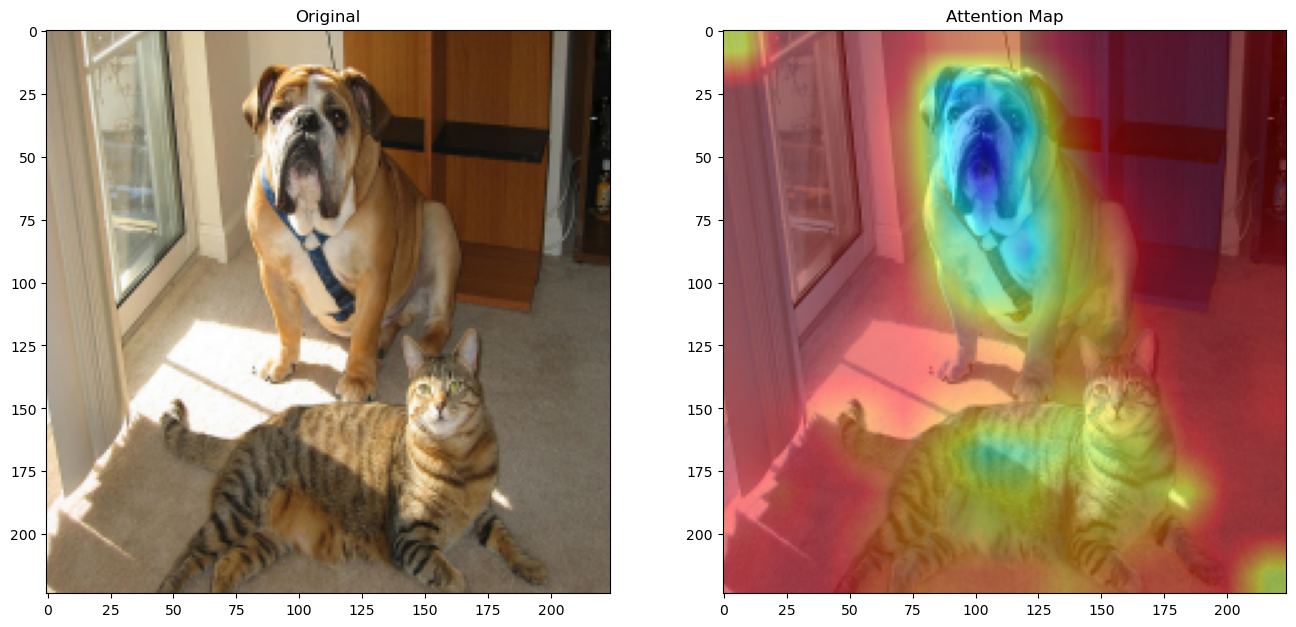

In [36]:
#@title Select the rollout strategy to be used and display results
#@markdown **Note** that for `grad_attention_rollout` passing a category index is mandatory.
rollout_strategy = "attention_rollout" #@param ["attention_rollout", "grad_attention_rollout"]
category_index =  264#@param {type:"integer"}

print(f"Using {rollout_strategy}")

input_tensor  = preprocess_image("examples/input.png", transform)

if rollout_strategy == "grad_attention_rollout" and category_index < 0:
    raise Exception("Category index is mandatory when using Gradient Attention Rollout")

elif rollout_strategy == "grad_attention_rollout" and category_index > 0:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=DISCARD_RATIO)
    mask = grad_rollout(input_tensor, category_index)
    name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index,
        DISCARD_RATIO, "mean")

elif rollout_strategy == "attention_rollout":
    attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
    mask = attention_rollout(input_tensor)
    name = "attention_rollout_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")

np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

# mask = (mask - mask.min()) / (mask.max() - mask.min())
# mask = mask.clip(0.7,1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(mask)

## Understanding the plot

In [27]:
np.array(img).shape

(224, 224, 3)

In [29]:
np.array(img)[:,:,::-1].shape # but they are inversed? -> to correct channel ordering to fit opencv one

(224, 224, 3)

# Attention Rollout, understanding algorithm

In [51]:
attention_rollout.attentions[-1].shape

torch.Size([1, 3, 197, 197])

## Experimenting with one attention layer

In [52]:
single_attention = attention_rollout.attentions[0]

In [53]:
single_attention.shape

torch.Size([1, 3, 197, 197])

In [54]:
single_attention.mean(axis = 1).shape

torch.Size([1, 197, 197])

In [55]:
single_attention.max(axis = 1)

torch.return_types.max(
values=tensor([[[0.2021, 0.0110, 0.0089,  ..., 0.0055, 0.0062, 0.0093],
         [0.3885, 0.2127, 0.0742,  ..., 0.0074, 0.0091, 0.0093],
         [0.3714, 0.1185, 0.0957,  ..., 0.0063, 0.0076, 0.0081],
         ...,
         [0.3617, 0.0058, 0.0022,  ..., 0.0911, 0.0761, 0.0742],
         [0.3635, 0.0060, 0.0022,  ..., 0.0666, 0.0900, 0.1315],
         [0.3817, 0.0061, 0.0025,  ..., 0.0330, 0.0660, 0.1950]]]),
indices=tensor([[[1, 0, 0,  ..., 2, 0, 0],
         [2, 0, 0,  ..., 1, 1, 1],
         [2, 0, 0,  ..., 1, 1, 1],
         ...,
         [2, 1, 1,  ..., 0, 0, 0],
         [2, 1, 1,  ..., 0, 0, 0],
         [2, 1, 1,  ..., 0, 0, 0]]]))

In [56]:
attention_heads_fused = single_attention.max(axis = 1)[0]

In [57]:
discard_ratio = 0.9

print(attention_heads_fused.sum())

flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
_, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
indices = indices[indices != 0]
flat[0, indices] = 0

print(attention_heads_fused.sum())

tensor(365.9828)
tensor(183.5572)


We see that indeed the flatten was simply to easily locate the elements

In [59]:
I = torch.eye(attention_heads_fused.size(-1))
I.shape

torch.Size([197, 197])

In [60]:
a = (attention_heads_fused + 1.0*I)/2

In [86]:
a.shape

torch.Size([1, 197, 197])

In [87]:
I = torch.eye(attention_heads_fused.size(-1))
a = (attention_heads_fused + 1.0*I)/2

In [97]:
a[0].sum(axis = 1)

tensor([1.0000, 1.1346, 1.1159, 1.1367, 1.1283, 1.1158, 1.1190, 1.1227, 1.1338,
        1.0969, 1.1131, 1.1062, 1.1013, 1.1250, 1.1349, 1.1211, 1.1167, 1.1147,
        1.1279, 1.1063, 1.1046, 1.1061, 1.1133, 1.1155, 1.1114, 1.1061, 1.0954,
        1.1154, 1.1291, 1.1260, 1.1154, 1.1210, 1.1191, 1.1034, 1.1275, 1.1380,
        1.1220, 1.1080, 1.1152, 1.1115, 1.1111, 1.1228, 1.1272, 1.1218, 1.1210,
        1.1145, 1.1082, 1.1096, 1.1158, 1.1296, 1.1208, 1.1051, 1.1054, 1.1071,
        1.1082, 1.1238, 1.1251, 1.1194, 1.1183, 1.1227, 1.1195, 1.1184, 1.1168,
        1.1186, 1.1015, 1.0999, 1.1115, 1.0975, 1.0949, 1.1205, 1.1346, 1.1253,
        1.1130, 1.1143, 1.1179, 1.1191, 1.1078, 1.1220, 1.1152, 1.0991, 1.1055,
        1.1025, 1.0979, 1.1183, 1.1226, 1.1228, 1.1217, 1.0947, 1.1091, 1.1105,
        1.1080, 1.1217, 1.1178, 1.1036, 1.1198, 1.1031, 1.0965, 1.1143, 1.1287,
        1.1224, 1.1102, 1.1038, 1.1105, 1.1166, 1.1120, 1.1026, 1.1049, 1.1072,
        1.1043, 1.1190, 1.1096, 1.1147, 

In [100]:
a.sum(dim = -1, keepdim=True).shape

torch.Size([1, 197, 1])

In [101]:
B = a / a.sum(dim=-1)


In [102]:
C = a / a.sum(dim=-1, keepdim=True)

In [103]:
B

tensor([[[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3232, 0.5322, 0.0340,  ..., 0.0000, 0.0000, 0.0000],
         [0.3090, 0.0520, 0.5023,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.3009, 0.0000, 0.0000,  ..., 0.5063, 0.0352, 0.0340],
         [0.3024, 0.0000, 0.0000,  ..., 0.0309, 0.5043, 0.0603],
         [0.3176, 0.0000, 0.0000,  ..., 0.0153, 0.0305, 0.5478]]])

In [104]:
C

tensor([[[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2848, 0.5322, 0.0335,  ..., 0.0000, 0.0000, 0.0000],
         [0.2769, 0.0528, 0.5023,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.2701, 0.0000, 0.0000,  ..., 0.5063, 0.0352, 0.0342],
         [0.2712, 0.0000, 0.0000,  ..., 0.0309, 0.5043, 0.0606],
         [0.2833, 0.0000, 0.0000,  ..., 0.0152, 0.0304, 0.5478]]])

In [94]:
a[0].sum(axis = 1)

tensor([1.0000, 1.1346, 1.1159, 1.1367, 1.1283, 1.1158, 1.1190, 1.1227, 1.1338,
        1.0969, 1.1131, 1.1062, 1.1013, 1.1250, 1.1349, 1.1211, 1.1167, 1.1147,
        1.1279, 1.1063, 1.1046, 1.1061, 1.1133, 1.1155, 1.1114, 1.1061, 1.0954,
        1.1154, 1.1291, 1.1260, 1.1154, 1.1210, 1.1191, 1.1034, 1.1275, 1.1380,
        1.1220, 1.1080, 1.1152, 1.1115, 1.1111, 1.1228, 1.1272, 1.1218, 1.1210,
        1.1145, 1.1082, 1.1096, 1.1158, 1.1296, 1.1208, 1.1051, 1.1054, 1.1071,
        1.1082, 1.1238, 1.1251, 1.1194, 1.1183, 1.1227, 1.1195, 1.1184, 1.1168,
        1.1186, 1.1015, 1.0999, 1.1115, 1.0975, 1.0949, 1.1205, 1.1346, 1.1253,
        1.1130, 1.1143, 1.1179, 1.1191, 1.1078, 1.1220, 1.1152, 1.0991, 1.1055,
        1.1025, 1.0979, 1.1183, 1.1226, 1.1228, 1.1217, 1.0947, 1.1091, 1.1105,
        1.1080, 1.1217, 1.1178, 1.1036, 1.1198, 1.1031, 1.0965, 1.1143, 1.1287,
        1.1224, 1.1102, 1.1038, 1.1105, 1.1166, 1.1120, 1.1026, 1.1049, 1.1072,
        1.1043, 1.1190, 1.1096, 1.1147, 

## All layers

In [11]:
attentions = attention_rollout.attentions
discard_ratio = 0.9

In [15]:
result = torch.eye(attentions[0].size(-1))
with torch.no_grad():
    for attention in attentions:
        attention_heads_fused = attention.mean(axis=1)

        # Drop the lowest attentions, but
        # don't drop the class token
        flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
        _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
        indices = indices[indices != 0]
        flat[0, indices] = 0

        I = torch.eye(attention_heads_fused.size(-1))
        a = (attention_heads_fused + 1.0*I)/2
        a = a / a.sum(dim=-1)
        # a = a / a.sum(dim=-1, keepdim=True)

        result = torch.matmul(a, result)

# Look at the total attention between the class token,
# and the image patches
mask = result[0, 0 , 1 :] # [0: batch(1 image),  ]
# In case of 224x224 image, this brings us from 196 to 14 $$ not my comment
width = int(mask.size(-1)**0.5)
mask = mask.reshape(width, width).numpy()
mask = mask / np.max(mask)

In [17]:
mask.shape

(14, 14)

In [ ]:
result[0, ]

In [14]:
result.shape

torch.Size([1, 197, 197])

# Getting classes

In [27]:
output = model(input_tensor)

In [29]:
output.shape

torch.Size([1, 1000])

In [55]:
import requests
import torch.nn.functional as F

LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
classes = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}

scores = model(input_tensor)

def print_preds(scores):
    # print the predictions with their 'probabilities' from the scores
    h_x = F.softmax(scores, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    # output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    return idx

_ = print_preds(scores)

0.266 -> ['n02108422', 'bull_mastiff']
0.062 -> ['n02108089', 'boxer']
0.039 -> ['n02123159', 'tiger_cat']
0.033 -> ['n02110958', 'pug']
0.023 -> ['n02123045', 'tabby']


# Remarks

So basically, raw attention we only need to look at the attentions correspondent to the class token.... 
Attention rollout we will perform the matrix multiplications to also get the attention flow thoroughout all layers